# Probabilistic Deep Learning on MNIST  
## From Deterministic CNNs to Bayesian Uncertainty with MC Dropout

This notebook presents a **exploration of uncertainty in deep neural networks** using the MNIST handwritten digit dataset.  
Rather than focusing solely on classification accuracy, the central objective is to **measure, analyze, and interpret predictive uncertainty**, a key requirement for **trustworthy and safety-critical AI systems**.

---

## Motivation

Modern deep learning models achieve impressive predictive performance, yet they typically output **overconfident point predictions** without reliable information about when they might be wrong.  
In real-world applications, models must be able to:

- Recognize **ambiguity and uncertainty**
- Detect **distributional shift or unfamiliar inputs**
- Provide **calibrated confidence estimates**
- Support **risk-aware decision making**

This notebook explores how **probabilistic deep learning** can address these challenges.

---

## Project Structure

The work is organized into two sections:

### Section 1 — Deterministic CNN Baseline
We first train a standard convolutional neural network to:

- Establish a **strong and reproducible classification baseline**
- Examine **softmax confidence and calibration**
- Analyze **misclassifications and reliability limitations**


### Section 2 — Bayesian CNN with Monte-Carlo Dropout
We then introduce **Monte-Carlo (MC) Dropout** as an **approximate Bayesian inference method** to obtain a **distribution of predictions** rather than a single point estimate.

In this phase we:

- Interpret dropout as **sampling from a posterior over model parameters**
- Estimate **predictive uncertainty** via repeated stochastic forward passes
- Measure:
  - Predictive variance  
  - Predictive entropy  
  - Epistemic uncertainty (mutual information)  
- Study uncertainty under **input perturbations** such as digit rotations



## Outlook

Quantifying uncertainty in deep neural networks is fundamental to:

- Bayesian deep learning  
- Out-of-distribution detection  
- Robust perception in safety-critical environments  
- Trustworthy and certifiable AI deployment  

This notebook provides a **minimal yet rigorous toy framework** demonstrating the transition from **deterministic prediction** to **uncertainty-aware probabilistic modeling**.

---

Future extensions may include:

- Deep ensembles and alternative Bayesian approximations  
- Calibration under distribution shift  
- Active learning driven by epistemic uncertainty  
- Operational Applicability Domain (OAD) estimation for safe deployment  


In [2]:
import numpy as np


import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import os
import json
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import random

from scipy.ndimage import rotate



In [4]:

# -------------------------------------------------------------------
# Reproducibility
# -------------------------------------------------------------------
def set_seed(seed: int = 42):
    """
    random seed for reproducibility across numpy and torch.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# Device helper
# ---------------------------------------------------------------------
def get_device():
    """
    Returns available device: CUDA → MPS → CPU.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")



In [15]:

# ---------------------------------------------------------------------
# Data loaders
# ---------------------------------------------------------------------
def get_dataloaders(batch_size: int = 128, data_dir: str = "./data"):
    """
    Returns train and test DataLoaders for MNIST.

    Args:
        batch_size: number of samples per batch
        data_dir: where MNIST will be downloaded/stored
    """

    # MNIST normalization statistics
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )

    # Datasets
    train_dataset = datasets.MNIST(
        root=data_dir,
        train=True,
        download=True,
        transform=transform,
    )

    test_dataset = datasets.MNIST(
        root=data_dir,
        train=False,
        download=True,
        transform=transform,
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
    )

    return train_loader, test_loader


In [16]:


set_seed(42)
device = get_device()
train_loader, test_loader = get_dataloaders(batch_size=64)

print("Device:", device)
print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)  # should be [64, 1, 28, 28]


Device: cpu
Train batches: 938
Test batches: 157
Batch shape: torch.Size([64, 1, 28, 28])


In [8]:


class BaselineCNN(nn.Module):
    """
    Simple CNN for MNIST classification.

    Designed to be:
    - minimal but strong baseline
    - compatible with Monte-Carlo Dropout later
    """

    def __init__(self, dropout_p: float = 0.5):
        super().__init__()

        # ----------------------------
        # Convolutional feature extractor
        # ----------------------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout in feature space (used later for MC Dropout)
        self.dropout_feat = nn.Dropout2d(p=0.25)

        # ----------------------------
        # Fully connected classifier
        # ----------------------------
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.dropout_fc = nn.Dropout(p=dropout_p)

        self.fc2 = nn.Linear(128, 10)

        # Initialize weights (good research habit)
        self._init_weights()

    # -----------------------------------
    # Forward pass
    # -----------------------------------
    def forward(self, x):
        """
        Input:  [batch, 1, 28, 28]
        Output: logits [batch, 10]
        """

        # Conv block 1
        x = F.relu(self.conv1(x))

        # Conv block 2 + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Feature dropout
        x = self.dropout_feat(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)

        logits = self.fc2(x)

        return logits  # IMPORTANT: no softmax here

    # --------------------------------------------------
    # Weight initialization
    # --------------------------------------------------
    def _init_weights(self):
        """
        Kaiming initialization improves training stability.
        """
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


In [9]:
model = BaselineCNN()
x = torch.randn(8, 1, 28, 28)

logits = model(x)

print("Output shape:", logits.shape)  # should be [8, 10]

Output shape: torch.Size([8, 10])


In [11]:


# ---------------
# Training 
# ---------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


# -------------------
# Evaluation 
# -------------------
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Evaluating", leave=False):
        
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item() * images.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy




In [12]:
# ------------------------------------
# Main training script
# -------------------------------------------
def main():

    # ---------- Parameters ----------
    seed = 42
    batch_size = 128
    epochs = 10
    learning_rate = 1e-3

    output_dir = "outputs"
    model_dir = os.path.join(output_dir, "models")
    os.makedirs(model_dir, exist_ok=True)

    # ---------- Reproducibility ----------
    set_seed(seed)

    # ---------- Device ----------
    device = get_device()
    print(f"Using device: {device}")

    # ---------- Data ----------
    train_loader, test_loader = get_dataloaders(batch_size=batch_size)

    # ---------- Model ----------
    model = BaselineCNN().to(device)

    # ---------- Loss & Optimizer ----------
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # ---------- History storage ----------
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    # ---------- Training loop ----------
    for epoch in range(1, epochs + 1):
        
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        test_loss, test_acc = evaluate(
            model, test_loader, criterion, device
        )

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
        )

        
    # ---------- Save model ----------
    model_path = os.path.join(model_dir, "baseline_cnn.pt")
    torch.save(model.state_dict(), model_path)
    print(f"\nModel saved to: {model_path}")

    # ---------- Save history ----------
    history_path = os.path.join(output_dir, "train_history.json")
    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)

    print(f"Training history saved to: {history_path}")


# --------------------------------------------------
if __name__ == "__main__":
    main()


Using device: cpu

Epoch 1/10


Train Loss: 0.4636 | Train Acc: 0.8677 | Test Loss: 0.0590 | Test Acc: 0.9813

Epoch 2/10


Train Loss: 0.1396 | Train Acc: 0.9583 | Test Loss: 0.0478 | Test Acc: 0.9841

Epoch 3/10


Train Loss: 0.1018 | Train Acc: 0.9699 | Test Loss: 0.0391 | Test Acc: 0.9868

Epoch 4/10


Train Loss: 0.0809 | Train Acc: 0.9751 | Test Loss: 0.0348 | Test Acc: 0.9889

Epoch 5/10


Train Loss: 0.0733 | Train Acc: 0.9777 | Test Loss: 0.0332 | Test Acc: 0.9892

Epoch 6/10


Train Loss: 0.0579 | Train Acc: 0.9816 | Test Loss: 0.0364 | Test Acc: 0.9884

Epoch 7/10


Train Loss: 0.0548 | Train Acc: 0.9829 | Test Loss: 0.0303 | Test Acc: 0.9900

Epoch 8/10


Train Loss: 0.0489 | Train Acc: 0.9849 | Test Loss: 0.0332 | Test Acc: 0.9901

Epoch 9/10


Train Loss: 0.0459 | Train Acc: 0.9854 | Test Loss: 0.0291 | Test Acc: 0.9915

Epoch 10/10


Train Loss: 0.0425 | Train Acc: 0.9861 | Test Loss: 0.0314 | Test Acc: 0.9906

Model saved to: outputs\models\baseline_cnn.pt
Training history saved to: outputs\train_history.json


In [14]:
# --------------------------------------------------
# Run inference on full dataset
# --------------------------------------------------
@torch.no_grad()
def collect_predictions(model, loader, device):
    
    """
    Runs model over the entire loader and collects:
    - logits
    - probabilities
    - predicted labels
    - true labels
    """

    model.eval()

    all_logits = []
    all_probs = []
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc="Collecting predictions"):
        
        images = images.to(device)

        logits = model(images)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Move to CPU for saving
        all_logits.append(logits.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(labels)

    # Concatenate all batches into full tensors
    all_logits = torch.cat(all_logits)
    all_probs = torch.cat(all_probs)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return all_logits, all_probs, all_preds, all_labels



In [21]:

# --------------------------------------------------
# Main evaluation script
# --------------------------------------------------
def main():

    # ---------- Paths ----------
    model_path = "outputs/models/baseline_cnn.pt"
    output_path = "outputs/predictions/baseline_test.npz"

    os.makedirs("outputs/predictions", exist_ok=True)

    # ---------- Device ----------
    device = get_device()
    print(f"Using device: {device}")

    # ---------- Data ----------
    _, test_loader = get_dataloaders(batch_size=128)

    # ---------- Model ----------
    model = BaselineCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    print("Model loaded successfully.")

    # ---------- Collect predictions ----------
    logits, probs, preds, labels = collect_predictions(
        model, test_loader, device
    )

    print("Inference complete.")
    print("Total samples:", labels.shape[0])

    # ---------- Save to disk ----------
    np.savez(
        output_path,
        logits=logits.numpy(),
        probs=probs.numpy(),
        preds=preds.numpy(),
        labels=labels.numpy(),
    )

    print(f"Saved predictions to: {output_path}")


# --------------------------------------------------
if __name__ == "__main__":
    main()

Using device: cpu
Model loaded successfully.


  warnings.warn(warn_msg)

Inference complete.
Total samples: 10000
Saved predictions to: outputs/predictions/baseline_test.npz


In [96]:

# Load model artifacts (update to your working directory ! )
pred_file = "C:/Users/the_w/outputs/predictions/baseline_test.npz"
history_file = "C:/Users/the_w/outputs/train_history.json"

data = np.load(pred_file)
logits = torch.tensor(data["logits"])
probs = torch.tensor(data["probs"])
preds = torch.tensor(data["preds"])
labels = torch.tensor(data["labels"])

with open(history_file, "r") as f:
    history = json.load(f)
    
print(f"Loaded {len(labels)} test samples.")


Loaded 10000 test samples.


In [97]:
# ------------------------------------------
#Basic Performance Metrics
# ------------------------------------------
# Test accuracy
accuracy = (preds == labels).float().mean().item()
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Negative Log-Likelihood (NLL)
nll = F.cross_entropy(logits, labels).item()
print(f"Test NLL: {nll:.4f}")


Test Accuracy: 99.06%
Test NLL: 0.0314


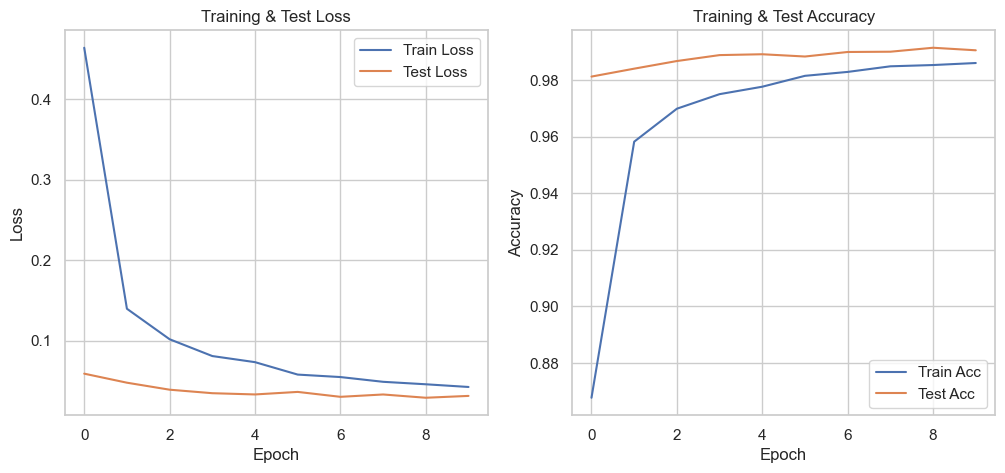

In [98]:
# ---------------------------
# Training Dynamics 
# ---------------------------
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Test Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["test_acc"], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy")
plt.legend()

plt.show()


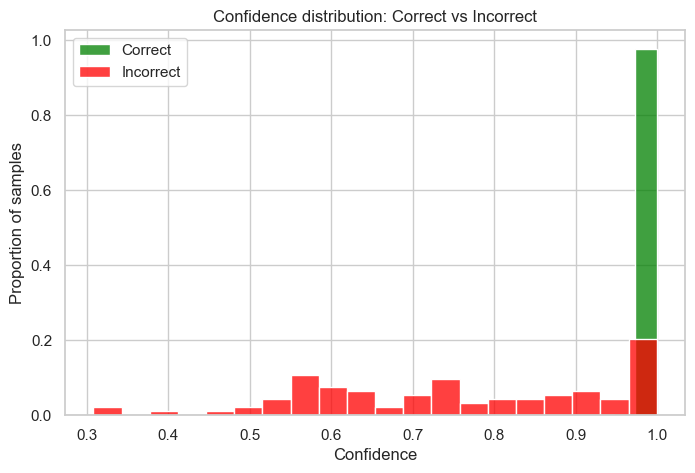

Mean confidence (correct): 0.996
Mean confidence (incorrect): 0.758


In [99]:
# ------------------------------------------
#  Confidence Analysis
# ------------------------------------------

# Confidence = max softmax probability
confidence = probs.max(dim=1).values

# Correct vs Incorrect
correct_conf = confidence[preds == labels]
incorrect_conf = confidence[preds != labels]

plt.figure(figsize=(8,5))
sns.histplot(correct_conf.numpy(), bins=20, color='green', label='Correct', kde=False, stat="probability")
sns.histplot(incorrect_conf.numpy(), bins=20, color='red', label='Incorrect', kde=False, stat="probability")
plt.xlabel("Confidence")
plt.ylabel("Proportion of samples")
plt.title("Confidence distribution: Correct vs Incorrect")
plt.legend()
plt.show()

print(f"Mean confidence (correct): {correct_conf.mean():.3f}")
print(f"Mean confidence (incorrect): {incorrect_conf.mean():.3f}")


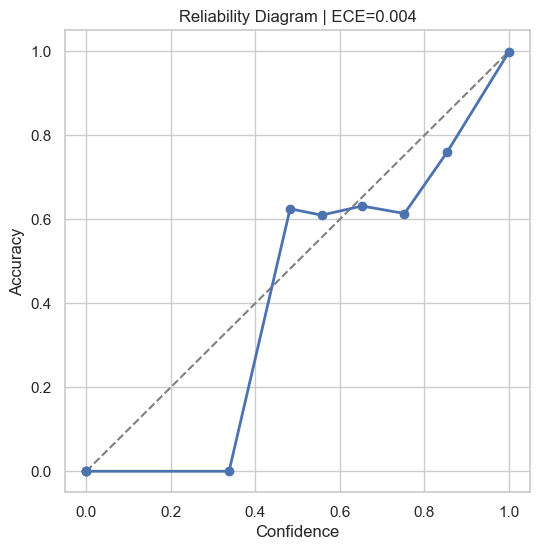

Expected Calibration Error (ECE): 0.004


In [7]:
# ------------------------------------------
#  Reliability Diagram & Expected Calibration Error (ECE)
# ------------------------------------------


def reliability_diagram(probs, preds, labels, n_bins=10):
    
    """
    plots reliability diagram and computes ECE
    """
    confidences = probs.max(dim=1).values
    accuracies = (preds == labels).float()

    bins = torch.linspace(0,1,n_bins+1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    ece = 0.0
    bin_accs = []
    bin_confs = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        
        mask = (confidences > bin_lower) & (confidences <= bin_upper)
        if mask.sum() > 0:
            
            acc = accuracies[mask].mean().item()
            conf = confidences[mask].mean().item()
            bin_accs.append(acc)
            bin_confs.append(conf)
            ece += (mask.sum().item() / len(labels)) * abs(acc - conf)
            
        else:
            
            bin_accs.append(0)
            bin_confs.append(0)

    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.plot(bin_confs, bin_accs, marker='o', linewidth=2)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(f"Reliability Diagram | ECE={ece:.3f}")
    plt.show()

    return ece


ece = reliability_diagram(probs, preds, labels, n_bins=10)
print(f"Expected Calibration Error (ECE): {ece:.3f}")


##  Bayesian CNN with Monte-Carlo Dropout

### Objective

The goal of this section is to move beyond deterministic prediction and enable the model to **quantify predictive uncertainty**.  
This is achieved using **Monte-Carlo (MC) Dropout**, which can be interpreted as an **approximate Bayesian inference method** in deep neural networks.

Instead of producing a single point prediction, the network performs **multiple stochastic forward passes** with dropout enabled at inference time.  
These repeated evaluations approximate the **posterior predictive distribution**, allowing uncertainty to be measured and analyzed.

---

### Key Concepts

- **Posterior Sampling via Dropout**  
  Each stochastic forward pass corresponds to sampling a different set of effective network weights, approximating draws from a Bayesian posterior.

- **Predictive Distribution**  
  Aggregating many stochastic predictions yields:
  - Mean prediction (expected class probabilities)
  - Variance and entropy (uncertainty measures)
  - Disagreement between sampled models (epistemic uncertainty)

- **Epistemic vs. Aleatoric Uncertainty**  
  Phase 2 focuses primarily on **epistemic uncertainty**, which reflects:
  - Limited knowledge of the model  
  - Sensitivity to unseen or ambiguous inputs  
  - Potential distributional shift  

---

### Analyses Performed

This phase introduces several quantitative and qualitative uncertainty analyses:

- **MC Dropout predictive statistics**
  - Predictive variance  
  - Predictive entropy  
  - Mutual information (epistemic uncertainty)

- **Confidence vs. correctness**
  - Comparison of deterministic softmax confidence with Bayesian uncertainty

- **Perturbation experiment (rotated digits)**
  - Gradual rotation of a single digit to traverse decision boundaries  
  - Observation of how predictive distributions evolve  
  - Measurement of uncertainty growth near ambiguous inputs  

This experiment provides a **geometric probe of the learned decision boundary** and the behavior of the approximate posterior.




In [40]:


# -------------------------------
# Bayesian CNN using MC Dropout
# -------------------------------
class BayesianCNN(nn.Module):
    
    def __init__(self, dropout_prob=0.3, num_classes=10):
        
        super(BayesianCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Dropout probability
        self.dropout_prob = dropout_prob
        
        # Dropout layers
        self.dropout_conv = nn.Dropout2d(p=dropout_prob)
        self.dropout_fc = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        
        # Convolution + ReLU + Dropout + Pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # MC Dropout
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)  # MC Dropout
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # MC Dropout
        
        # Output layer
        x = self.fc2(x)
        
        return x

# -------------------------------
# Test model creation
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BayesianCNN(dropout_prob=0.3, num_classes=10).to(device)
print(model)

# Optional: test a forward pass
sample_input = torch.randn(8, 1, 28, 28).to(device)  # batch of 8 MNIST-like images
output = model(sample_input)
print("Output shape:", output.shape)  # should be [8, 10]


BayesianCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout_conv): Dropout2d(p=0.3, inplace=False)
  (dropout_fc): Dropout(p=0.3, inplace=False)
)
Output shape: torch.Size([8, 10])


In [43]:


def mc_dropout_predict(model, inputs, T=50, device="cpu"):
    """
    Perform Monte-Carlo Dropout predictions for a batch of inputs.

    Args:
        model: PyTorch Bayesian CNN
        inputs: input batch, shape [batch_size, channels, H, W]
        T: number of stochastic forward passes
        device: 'cpu' or 'cuda'

    Returns:
        mean_probs: mean softmax probabilities over T passes [batch_size, num_classes]
        std_probs: standard deviation of softmax probabilities [batch_size, num_classes]
        preds: predicted class labels (argmax of mean_probs) [batch_size]
    """
    model.train()  # Keep dropout active for MC sampling
    inputs = inputs.to(device)
    
    probs_T = []
    
    with torch.no_grad():
        
        for t in range(T):
                       
            logits = model(inputs)                  # Forward pass
            probs = F.softmax(logits, dim=1)       # Convert logits to probabilities
            probs_T.append(probs.unsqueeze(1))     # Shape: [B, 1, C]

            
    probs_T = torch.cat(probs_T, dim=1)       # Shape: [B, T, C]  <- batch first, T passes second

    mean_probs = probs_T.mean(dim=1)          # Mean over T passes → [B, C]
    std_probs = probs_T.std(dim=1)            # Std over T passes → [B, C]

    preds = mean_probs.argmax(dim=1)          # Predicted class → [B]

        
        
    

    """
    Returns:
        mean_probs  : [B, C]
        std_probs   : [B, C]
        preds       : [B]
        probs_T     : [B, T, C] 
    """    
        
    return mean_probs, std_probs, preds, probs_T






In [44]:
# Assume model is your BayesianCNN
# sample_input: batch of 8 MNIST images

mean_probs, std_probs, preds, probs_T = mc_dropout_predict(model, sample_input, T=50, device=device)

print("Mean probabilities:\n", mean_probs)
print("")
print("Predictive uncertainty (std):\n", std_probs)
print("")
print("Predicted classes:", preds)
print("")
print("MC predictive samples:", probs_T)

Mean probabilities:
 tensor([[0.1221, 0.1082, 0.1020, 0.0922, 0.0917, 0.0903, 0.0987, 0.1049, 0.1070,
         0.0829],
        [0.1239, 0.1093, 0.0987, 0.0903, 0.0932, 0.0965, 0.0996, 0.0991, 0.1056,
         0.0837],
        [0.1147, 0.1117, 0.1019, 0.0916, 0.0910, 0.0942, 0.1039, 0.1023, 0.1094,
         0.0792],
        [0.1207, 0.1110, 0.0985, 0.0884, 0.0918, 0.0934, 0.1023, 0.1027, 0.1082,
         0.0830],
        [0.1181, 0.1125, 0.1043, 0.0909, 0.0914, 0.0951, 0.0963, 0.1001, 0.1064,
         0.0850],
        [0.1172, 0.1120, 0.0990, 0.0912, 0.0970, 0.0948, 0.0993, 0.1005, 0.1035,
         0.0855],
        [0.1189, 0.1129, 0.1003, 0.0901, 0.0927, 0.0925, 0.0978, 0.1062, 0.1085,
         0.0800],
        [0.1141, 0.1094, 0.1042, 0.0912, 0.0910, 0.0959, 0.1001, 0.1026, 0.1062,
         0.0853]])

Predictive uncertainty (std):
 tensor([[0.0117, 0.0133, 0.0085, 0.0098, 0.0094, 0.0120, 0.0089, 0.0109, 0.0089,
         0.0086],
        [0.0109, 0.0134, 0.0094, 0.0085, 0.0077, 0.0146

In [45]:


# -------------------------------
# Hyperparameters
# -------------------------------
batch_size = 64
learning_rate = 1e-3
num_epochs = 10  
dropout_prob = 0.3

# -------------------------------
# Dataset & DataLoader (example MNIST)
# -------------------------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# Model, Loss, Optimizer
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BayesianCNN(dropout_prob=dropout_prob, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------------
# Training Loop
# -------------------------------
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(num_epochs):
    
    # --- Training ---
    model.train()  # Dropout active during training
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    
    # --- Testing ---
    model.eval()  # Dropout off for standard evaluation
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= total
    test_acc = correct / total
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch [1/10] Train Loss: 0.2213, Train Acc: 0.9329 Test Loss: 0.0510, Test Acc: 0.9834
Epoch [2/10] Train Loss: 0.0886, Train Acc: 0.9735 Test Loss: 0.0373, Test Acc: 0.9883
Epoch [3/10] Train Loss: 0.0690, Train Acc: 0.9794 Test Loss: 0.0289, Test Acc: 0.9916
Epoch [4/10] Train Loss: 0.0583, Train Acc: 0.9828 Test Loss: 0.0288, Test Acc: 0.9904
Epoch [5/10] Train Loss: 0.0499, Train Acc: 0.9844 Test Loss: 0.0261, Test Acc: 0.9908
Epoch [6/10] Train Loss: 0.0455, Train Acc: 0.9858 Test Loss: 0.0298, Test Acc: 0.9896
Epoch [7/10] Train Loss: 0.0396, Train Acc: 0.9868 Test Loss: 0.0269, Test Acc: 0.9915
Epoch [8/10] Train Loss: 0.0367, Train Acc: 0.9887 Test Loss: 0.0247, Test Acc: 0.9907
Epoch [9/10] Train Loss: 0.0352, Train Acc: 0.9891 Test Loss: 0.0237, Test Acc: 0.9919
Epoch [10/10] Train Loss: 0.0310, Train Acc: 0.9898 Test Loss: 0.0232, Test Acc: 0.9922


In [57]:

# -------------------------------
# Hyperparameters for MC Dropout
# -------------------------------
T = 50  # Number of stochastic forward passes

# -------------------------------
# Storage for test predictions
# -------------------------------
all_mean_probs = []
all_std_probs = []
all_preds = []
all_labels = []
all_images = []

model.eval()  # Turn off dropout for standard evaluation, will activate inside mc_dropout_predict

# -------------------------------
# Loop over test set
# -------------------------------
for images, labels in test_loader:
    
    images, labels = images.to(device), labels.to(device)
    
    # Run MC Dropout prediction
    mean_probs, std_probs, preds, probs_T = mc_dropout_predict(model, images, T=T, device=device)
    
    # Store results
    all_mean_probs.append(mean_probs.cpu())
    all_std_probs.append(std_probs.cpu())
    all_preds.append(preds.cpu())
    all_labels.append(labels.cpu())
    all_images.append(images.cpu())

    

# Concatenate all batches
all_mean_probs = torch.cat(all_mean_probs)  # [num_test_samples, num_classes]
all_std_probs = torch.cat(all_std_probs)    # [num_test_samples, num_classes]
all_preds = torch.cat(all_preds)            # [num_test_samples]
all_labels = torch.cat(all_labels)          # [num_test_samples]
all_images = torch.cat(all_images)          # [num_test_samples, 1, 28, 28]

# -------------------------------
# Compute confidence (max probability)
# -------------------------------
confidence = all_mean_probs.max(dim=1).values


# ---------------------------------------------------------
# Accuracy using Bayesian mean prediction
# ---------------------------------------------------------

bayes_acc = (all_preds == all_labels).float().mean()



# -------------------------------
# Print summary statistics
# -------------------------------
accuracy = (all_preds == all_labels).float().mean()
mean_conf_correct = confidence[all_preds == all_labels].mean()
mean_conf_incorrect = confidence[all_preds != all_labels].mean()

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean confidence (correct predictions): {mean_conf_correct:.3f}")
print(f"Mean confidence (incorrect predictions): {mean_conf_incorrect:.3f}")
print(f"Bayesian MC Dropout Accuracy: {bayes_acc:.4f}")


Test Accuracy: 0.9925
Mean confidence (correct predictions): 0.985
Mean confidence (incorrect predictions): 0.625
Bayesian MC Dropout Accuracy: 0.9925


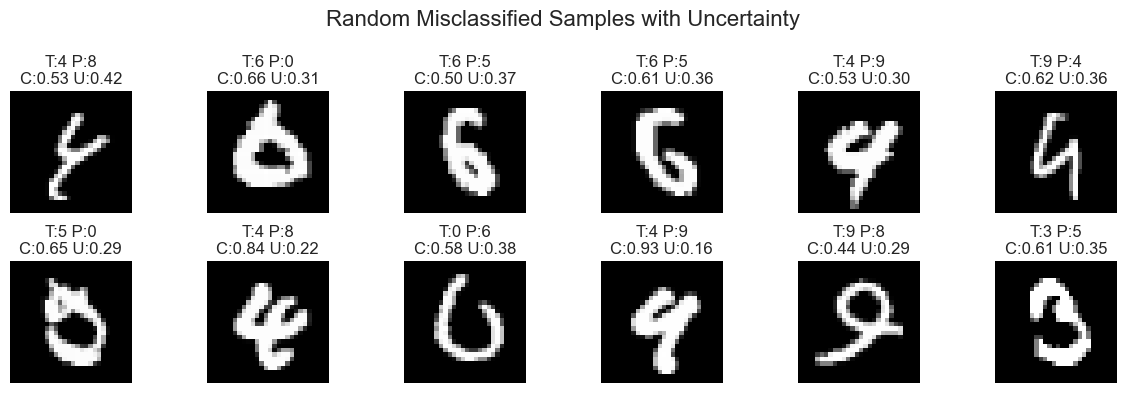

In [58]:

# -------------------------------
# Misclassified indices
# -------------------------------
misclassified_idx = (all_preds != all_labels).nonzero(as_tuple=True)[0]

if len(misclassified_idx) == 0:
    print("No misclassified examples!")
else:
    # Randomly select up to 12 misclassified samples
    random_idx = random.sample(list(misclassified_idx.numpy()), min(12, len(misclassified_idx)))

    plt.figure(figsize=(12,4))
    for i, idx in enumerate(random_idx):
        plt.subplot(2,6,i+1)
        img = all_images[idx].squeeze()  # Remove channel dimension if needed
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(
            f"T:{all_labels[idx].item()} "  # True label
            f"P:{all_preds[idx].item()}\n"  # Predicted label
            f"C:{confidence[idx]:.2f} "     # Confidence
            f"U:{all_std_probs[idx].max():.2f}"  # Predictive uncertainty (max class)
        )
    plt.suptitle("Random Misclassified Samples with Uncertainty", fontsize=16)
    plt.tight_layout()
    plt.show()


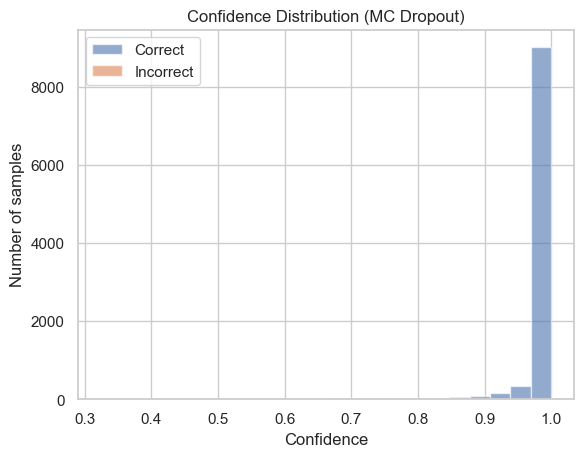

Mean confidence (correct): 0.985
Mean confidence (incorrect): 0.625


In [59]:


# Convert to numpy
conf_np = confidence.numpy()
preds_np = all_preds.numpy()
labels_np = all_labels.numpy()

# Separate correct vs incorrect
correct_conf = conf_np[preds_np == labels_np]
incorrect_conf = conf_np[preds_np != labels_np]

plt.figure()
plt.hist(correct_conf, bins=20, alpha=0.6, label="Correct")
plt.hist(incorrect_conf, bins=20, alpha=0.6, label="Incorrect")

plt.xlabel("Confidence")
plt.ylabel("Number of samples")
plt.title("Confidence Distribution (MC Dropout)")
plt.legend()
plt.show()

print(f"Mean confidence (correct): {correct_conf.mean():.3f}")
print(f"Mean confidence (incorrect): {incorrect_conf.mean():.3f}")


In [60]:
def compute_ece(confidence, preds, labels, n_bins=15):
    """
    Compute Expected Calibration Error (ECE)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    bin_acc = []
    bin_conf = []

    for i in range(n_bins):
        bin_mask = (confidence > bins[i]) & (confidence <= bins[i+1])

        if np.any(bin_mask):
            acc = (preds[bin_mask] == labels[bin_mask]).mean()
            conf = confidence[bin_mask].mean()
            weight = bin_mask.mean()

            ece += np.abs(acc - conf) * weight

            bin_acc.append(acc)
            bin_conf.append(conf)
        else:
            bin_acc.append(0)
            bin_conf.append(0)

    return ece, np.array(bin_acc), np.array(bin_conf), bins


In [61]:
ece, bin_acc, bin_conf, bins = compute_ece(conf_np, preds_np, labels_np)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0106


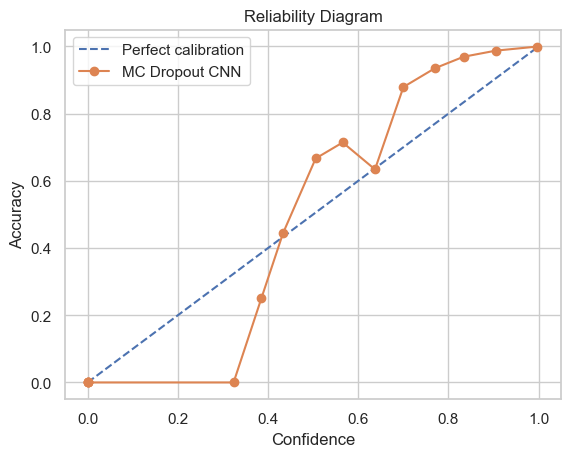

In [65]:
plt.figure()

# Perfect calibration line
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")

# Model reliability
plt.plot(bin_conf, bin_acc, marker="o", label="MC Dropout CNN")

plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.show()


In [66]:
all_mc_probs = []

model.eval()

for images, labels in test_loader:
    images = images.to(device)

    # NEW: mc_dropout_predict must return probs_T
    mean_probs, std_probs, preds, probs_T = mc_dropout_predict(
        model, images, T=T, device=device
    )

    all_mc_probs.append(probs_T.cpu())

all_mc_probs = torch.cat(all_mc_probs)   # [N, T, C]


In [67]:
def compute_uncertainty_metrics(mc_probs, eps=1e-10):
    """
    mc_probs: [N, T, C] tensor of MC softmax probabilities
    Returns:
        predictive_entropy: [N]
        mutual_information: [N]
    """

    # Mean predictive distribution
    mean_probs = mc_probs.mean(dim=1)  # [N, C]

    # ----- Predictive entropy -----
    predictive_entropy = -torch.sum(
        mean_probs * torch.log(mean_probs + eps), dim=1
    )

    # ----- Expected entropy over MC samples -----
    sample_entropies = -torch.sum(
        mc_probs * torch.log(mc_probs + eps), dim=2
    )  # [N, T]

    expected_entropy = sample_entropies.mean(dim=1)  # [N]

    # ----- Mutual information -----
    mutual_information = predictive_entropy - expected_entropy

    return predictive_entropy, mutual_information


In [68]:
pred_entropy, mutual_info = compute_uncertainty_metrics(all_mc_probs)


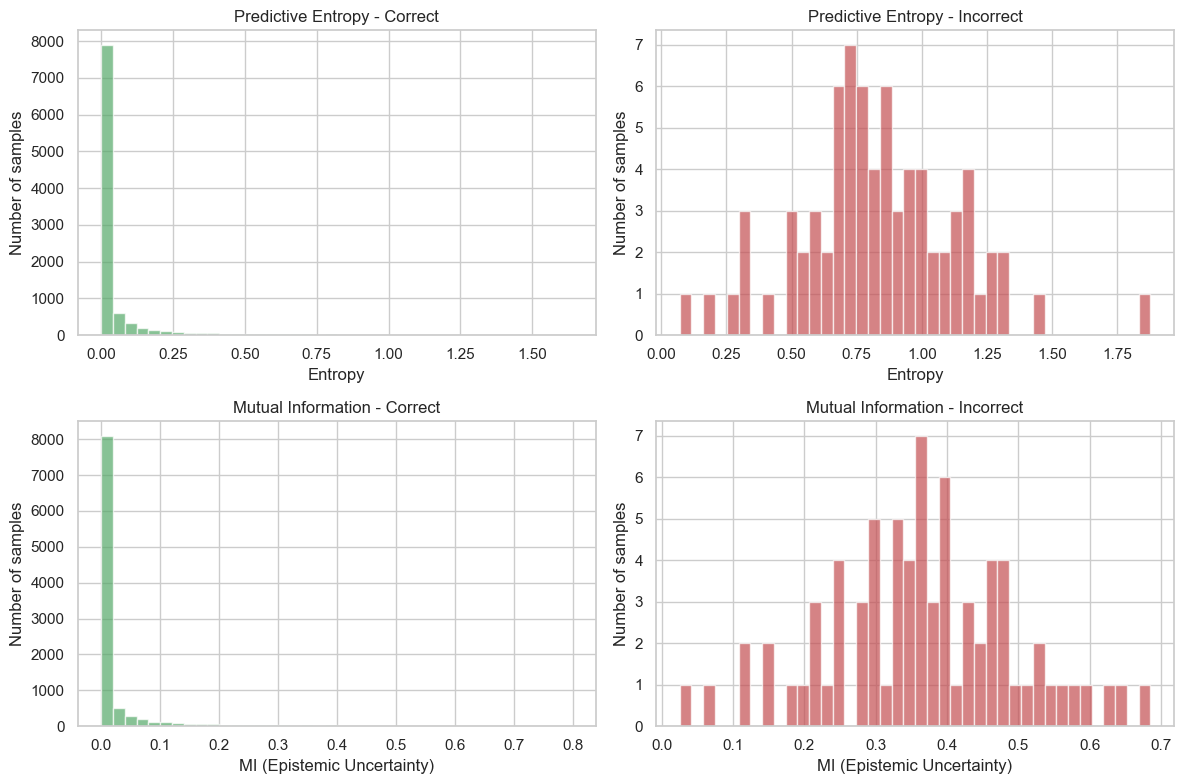

In [71]:
correct_mask = (all_preds == all_labels)

plt.figure(figsize=(12,8))

# Predictive Entropy - Correct
plt.subplot(2,2,1)
plt.hist(pred_entropy[correct_mask].numpy(), bins=40, alpha=0.7, color='g')
plt.title("Predictive Entropy - Correct")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")

# Predictive Entropy - Incorrect
plt.subplot(2,2,2)
plt.hist(pred_entropy[~correct_mask].numpy(), bins=40, alpha=0.7, color='r')
plt.title("Predictive Entropy - Incorrect")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")

# Mutual Information - Correct
plt.subplot(2,2,3)
plt.hist(mutual_info[correct_mask].numpy(), bins=40, alpha=0.7, color='g')
plt.title("Mutual Information - Correct")
plt.xlabel("MI (Epistemic Uncertainty)")
plt.ylabel("Number of samples")

# Mutual Information - Incorrect
plt.subplot(2,2,4)
plt.hist(mutual_info[~correct_mask].numpy(), bins=40, alpha=0.7, color='r')
plt.title("Mutual Information - Incorrect")
plt.xlabel("MI (Epistemic Uncertainty)")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()





In [109]:


# Get all test data in one batch
test_loader = get_dataloaders(batch_size=128)[1]  # test_loader
X_test, y_test = next(iter(test_loader))  # [N,1,28,28]
X_test = X_test.numpy()
y_test = y_test.numpy()

# Pick one clean digit, for instance, digit 4
digit_idx = np.where(y_test==4)[0][0]
base_img = X_test[digit_idx].squeeze()  # shape (28,28)

# Generate rotated versions
angles = np.linspace(0, 360, num=15)
X_rot = np.array([rotate(base_img, angle, reshape=False) for angle in angles])
X_rot = X_rot[:, None, :, :]  # [12,1,28,28]





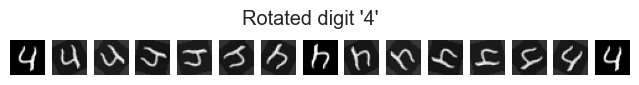

In [110]:
plt.figure(figsize=(8,1))

for i in range(len(X_rot)):
    
    plt.subplot(1, len(X_rot), i+1)
    plt.imshow(X_rot[i].squeeze(), cmap='gray')
    plt.axis('off')
    
plt.suptitle("Rotated digit '4'")
plt.show()


In [111]:


def mc_predict(model, X, T=500, device='cuda'):
    """
    Run MC Dropout predictions.
    Returns logits and softmax probabilities.
    """
    model.train()  # keep dropout active
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    logits_list = []
    probs_list = []
    
    with torch.no_grad():
        
        for _ in range(T):
            
            logits = model(X_tensor)
            probs = F.softmax(logits, dim=1)
            logits_list.append(logits.cpu().numpy())
            probs_list.append(probs.cpu().numpy())
    
    return np.array(logits_list), np.array(probs_list)


In [116]:
logits_mc, probs_mc = mc_predict(model, X_rot, T=1000, device=device)


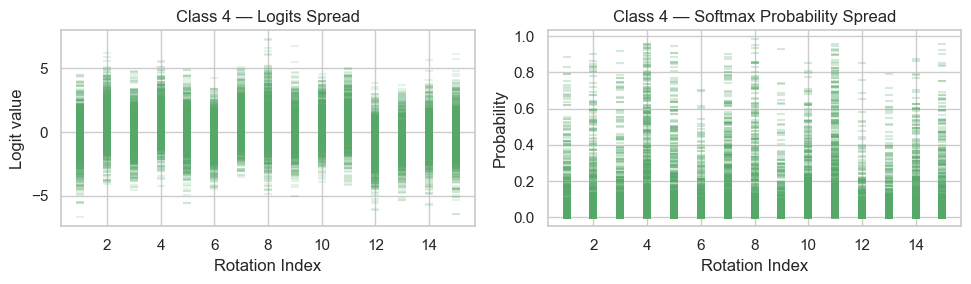

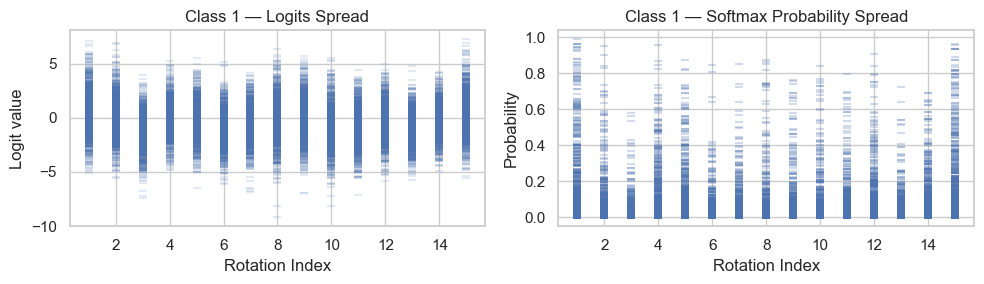

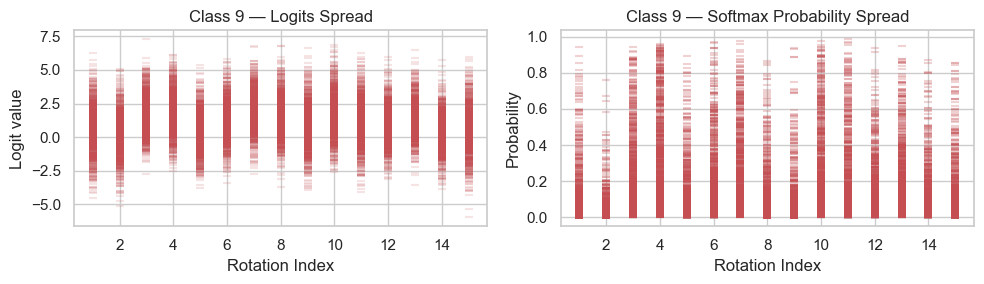

In [117]:
classes_to_plot = [4, 1, 9]
colors = ['g', 'b', 'r']

rotation_idx = np.arange(1, probs_mc.shape[1] + 1)

for cls, color in zip(classes_to_plot, colors):

    plt.figure(figsize=(10, 3))

    # ---------------------------
    # Logits scatter
    # ---------------------------
    plt.subplot(1, 2, 1)
    plt.scatter(
        np.tile(rotation_idx, logits_mc.shape[0]),
        logits_mc[:, :, cls].flatten(),
        color=color,
        alpha=0.15,
        marker='_'
    )
    plt.title(f"Class {cls} — Logits Spread")
    plt.xlabel("Rotation Index")
    plt.ylabel("Logit value")

    # ---------------------------
    # Softmax scatter
    # ---------------------------
    plt.subplot(1, 2, 2)
    plt.scatter(
        np.tile(rotation_idx, probs_mc.shape[0]),
        probs_mc[:, :, cls].flatten(),
        color=color,
        alpha=0.25,
        marker='_'
    )
    plt.title(f"Class {cls} — Softmax Probability Spread")
    plt.xlabel("Rotation Index")
    plt.ylabel("Probability")

    plt.tight_layout()
    plt.show()



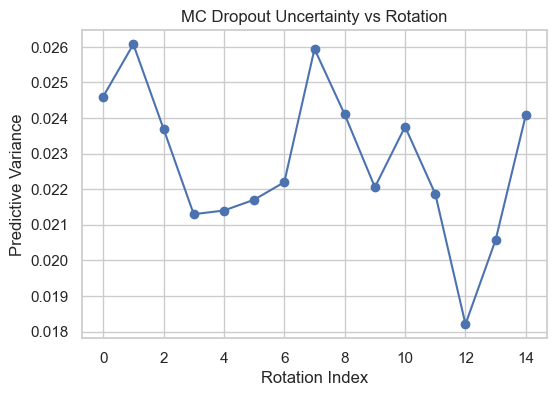

In [118]:
variance_per_rotation = probs_mc.var(axis=0).mean(axis=1)  # mean over classes

plt.figure(figsize=(6,4))
plt.plot(variance_per_rotation, marker='o')
plt.xlabel("Rotation Index")
plt.ylabel("Predictive Variance")
plt.title("MC Dropout Uncertainty vs Rotation")
plt.show()


